In [39]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib
import matplotlib.pyplot as plt
from credentials import Credentials as cr
from prediction import ImmothepPrediction
import os
from split import Splitter
from sklearn.ensemble import IsolationForest
import requests

splitter = Splitter()
predictor = ImmothepPrediction()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Création et import du jeu de données principal

In [54]:
valeurs2019 = pd.read_csv(cr.PATH + cr.DATASET_NAME, sep='|', usecols=['Nature mutation', 'Code postal','Nombre pieces principales', 'Surface terrain', 'Surface Carrez du 1er lot', 'Surface Carrez du 2eme lot', 'Surface Carrez du 3eme lot', 'Surface Carrez du 4eme lot', 'Surface Carrez du 5eme lot', 'Valeur fonciere', 'Type local', 'Nombre de lots'], encoding='utf-8')

valeurs2019 = valeurs2019.dropna(subset = ['Type local', 'Nombre de lots', 'Nombre pieces principales', "Nature mutation"])

valeurs2019['Surface terrain'][valeurs2019['Type local'].str.contains("Appartement", regex=True)] = valeurs2019['Surface terrain'][valeurs2019['Type local'].str.contains("Appartement", regex=True)].fillna(0) 

valeurs2019 = valeurs2019[['Code postal', 'Nombre pieces principales', 'Surface terrain', 'Surface Carrez du 1er lot', 'Surface Carrez du 2eme lot', 'Surface Carrez du 3eme lot', 'Surface Carrez du 4eme lot', 'Surface Carrez du 5eme lot', 'Valeur fonciere']][valeurs2019['Type local'].str.contains("Appartement|Maison", regex=True)][valeurs2019['Nature mutation'].str.contains("Vente", regex=True)][valeurs2019['Nombre de lots']<6][valeurs2019['Nombre pieces principales']>0]

valeurs2019.head()

,Code postal,Nombre pieces principales,Surface terrain,Surface Carrez du 1er lot,Surface Carrez du 2eme lot,Surface Carrez du 3eme lot,Surface Carrez du 4eme lot,Surface Carrez du 5eme lot,Valeur fonciere
0,1000.0,1.0,0.0,"19,27",NaN,NaN,NaN,NaN,"37220,00"
1,1000.0,3.0,0.0,NaN,"61,51",NaN,NaN,NaN,"185100,00"
3,1160.0,4.0,940.0,NaN,NaN,NaN,NaN,NaN,"209000,00"
4,1370.0,5.0,490.0,NaN,NaN,NaN,NaN,NaN,"134900,00"
5,1340.0,4.0,708.0,NaN,NaN,NaN,NaN,NaN,"192000,00"


In [55]:
# Vérification du ratio de valeurs nulles en vue de nettoyer les données.

nancount = valeurs2019["Valeur fonciere"].isna()
print ("Il y a ", nancount.sum(), " valeurs nulles dans la colonne \'Valeur Foncière\'.")
valeurs2019 = valeurs2019.dropna(subset = ['Valeur fonciere'])
nancount = valeurs2019["Valeur fonciere"].isna()
print ("Il y a ", nancount.sum(), " valeurs nulles dans la colonne \'Valeur Foncière\'.")

nancount = valeurs2019["Code postal"].isna()
print ("Il y a ", nancount.sum(), " valeurs nulles dans la colonne \'Code postal\'.")
valeurs2019 = valeurs2019.dropna(subset = ['Code postal'])
nancount = valeurs2019["Code postal"].isna()
print ("Il y a ", nancount.sum(), " valeurs nulles dans la colonne \'Code postal\'.")


Il y a  3615  valeurs nulles dans la colonne 'Valeur Foncière'.
Il y a  0  valeurs nulles dans la colonne 'Valeur Foncière'.
Il y a  54  valeurs nulles dans la colonne 'Code postal'.
Il y a  0  valeurs nulles dans la colonne 'Code postal'.


In [56]:
valeurs2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 935516 entries, 0 to 2535790
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Code postal                 935516 non-null  float64
 1   Nombre pieces principales   935516 non-null  float64
 2   Surface terrain             913663 non-null  float64
 3   Surface Carrez du 1er lot   187593 non-null  object 
 4   Surface Carrez du 2eme lot  50988 non-null   object 
 5   Surface Carrez du 3eme lot  4175 non-null    object 
 6   Surface Carrez du 4eme lot  842 non-null     object 
 7   Surface Carrez du 5eme lot  207 non-null     object 
 8   Valeur fonciere             935516 non-null  object 
dtypes: float64(3), object(6)
memory usage: 71.4+ MB


In [57]:
valeurs2019[['Valeur fonciere', 'Surface Carrez du 1er lot', 'Surface Carrez du 2eme lot', 'Surface Carrez du 3eme lot', 'Surface Carrez du 4eme lot', 'Surface Carrez du 5eme lot']] = valeurs2019[['Valeur fonciere', 'Surface Carrez du 1er lot', 'Surface Carrez du 2eme lot', 'Surface Carrez du 3eme lot', 'Surface Carrez du 4eme lot', 'Surface Carrez du 5eme lot']].replace(',', '.', regex=True)

valeurs2019[['Valeur fonciere', 'Surface Carrez du 1er lot', 'Surface Carrez du 2eme lot', 'Surface Carrez du 3eme lot', 'Surface Carrez du 4eme lot', 'Surface Carrez du 5eme lot']]  = valeurs2019[['Valeur fonciere', 'Surface Carrez du 1er lot', 'Surface Carrez du 2eme lot', 'Surface Carrez du 3eme lot', 'Surface Carrez du 4eme lot', 'Surface Carrez du 5eme lot']].astype('float')

In [58]:
valeurs2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 935516 entries, 0 to 2535790
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Code postal                 935516 non-null  float64
 1   Nombre pieces principales   935516 non-null  float64
 2   Surface terrain             913663 non-null  float64
 3   Surface Carrez du 1er lot   187593 non-null  float64
 4   Surface Carrez du 2eme lot  50988 non-null   float64
 5   Surface Carrez du 3eme lot  4175 non-null    float64
 6   Surface Carrez du 4eme lot  842 non-null     float64
 7   Surface Carrez du 5eme lot  207 non-null     float64
 8   Valeur fonciere             935516 non-null  float64
dtypes: float64(9)
memory usage: 71.4 MB


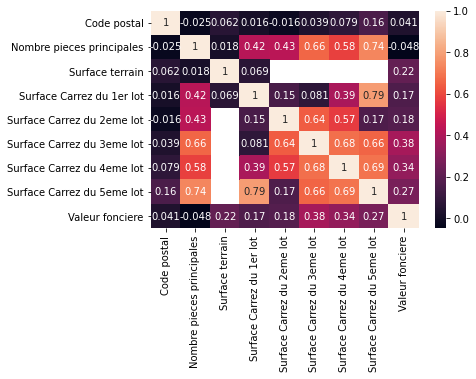

In [59]:
corrMatrix = valeurs2019.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

### Ajustement du dataset

In [60]:
valeurs2019 = valeurs2019[valeurs2019['Valeur fonciere']>200]

nancount = valeurs2019["Surface terrain"].isna()
print ("Il y a ", nancount.sum(), " valeurs nulles dans la colonne \'Surface Terrain\'.")
valeurs2019 = valeurs2019.dropna(subset = ['Surface terrain'])

nancount = valeurs2019["Surface terrain"].isna()
print ("Il y a ", nancount.sum(), " valeurs nulles dans la colonne \'Surface Terrain\'.")

valeurs2019 = valeurs2019.fillna(0)

Il y a  21748  valeurs nulles dans la colonne 'Surface Terrain'.
Il y a  0  valeurs nulles dans la colonne 'Surface Terrain'.


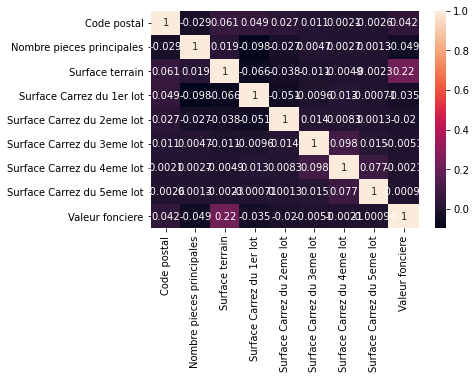

In [61]:
corrMatrix = valeurs2019.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

Test de la prédiction de la valeur foncière sur l'élémant d'index 5 de valeurs2019

In [ ]:
predictor = ImmothepPrediction()

try:
    result = predictor.predict(valeurs2019, 5)
except : 
    print('Elément non trouvé.')

# Pas d'outpout car méthode supprimée à postériori.

### Modification du modèle avec méthode d'entraînement et méthode de test

In [ ]:
modele, scaler, lab_enc = predictor.entrainementLR(valeurs2019)
result = predictor.predictionLR(valeurs2019[valeurs2019.index==693], modele, scaler, lab_enc)
# Pas d'outpout car méthode supprimée à postériori.

### Modification du dataset pour rendre la prédiction plus précise

(Il y avait des scatter plots de 300MB ici)

In [ ]:
valeurs2019 = valeurs2019[valeurs2019['Valeur fonciere']<60000000]
valeurs2019 = valeurs2019[valeurs2019['Surface terrain']<400000]

(Ici aussi)

### Nouveau test de prédiction

In [ ]:
modele, scaler, lab_enc = predictor.entrainementLR(valeurs2019)
predictor.predictionLR(valeurs2019[valeurs2019.index==5], modele, scaler, lab_enc)

Résultats non satisfaisants.

### Export du premier dataset de travail en tant que sauvegarde

In [ ]:
valeurs2019.to_csv(cr.CURATED_LOCAL_PATH + 'filtered2019.csv', index=False)

## Création d'un nouveau dataset avec des attributs différents

In [107]:
valeurs2019 = pd.read_csv(cr.PATH + cr.DATASET_NAME, sep='|', usecols=['Nature mutation', 'Code postal','Nombre pieces principales', 'Surface terrain', 'Surface reelle bati', 'Valeur fonciere', 'Type local', 'Nombre de lots'], encoding='utf-8')

valeurs2019 = valeurs2019.dropna(subset = ['Type local', 'Nombre de lots', 'Nombre pieces principales', 'Nature mutation', 'Surface reelle bati'])

valeurs2019['Surface terrain'][valeurs2019['Type local'].str.contains("Appartement", regex=True)] = valeurs2019['Surface terrain'][valeurs2019['Type local'].str.contains("Appartement", regex=True)].fillna(0) 

valeurs2019 = valeurs2019[['Type local', 'Code postal', 'Nombre pieces principales', 'Surface terrain', 'Surface reelle bati', 'Valeur fonciere']][valeurs2019['Type local'].str.contains("Appartement|Maison", regex=True)][valeurs2019['Nombre de lots']<2][valeurs2019['Nombre pieces principales']>0]#[valeurs2019['Nature mutation'].str.contains("Vente", regex=True)]

valeurs2019.head()


,Type local,Code postal,Nombre pieces principales,Surface terrain,Surface reelle bati,Valeur fonciere
0,Appartement,1000.0,1.0,0.0,20.0,"37220,00"
3,Maison,1160.0,4.0,940.0,90.0,"209000,00"
4,Maison,1370.0,5.0,490.0,101.0,"134900,00"
5,Maison,1340.0,4.0,708.0,88.0,"192000,00"
6,Maison,1250.0,2.0,631.0,39.0,"45000,00"


### Vérification du ratio de valeurs nulles en vue de nettoyer les données.

In [108]:
nancount = valeurs2019["Valeur fonciere"].isna()
print ("Il y a ", nancount.sum(), " valeurs nulles dans la colonne \'Valeur Foncière\'.")
valeurs2019 = valeurs2019.dropna(subset = ['Valeur fonciere'])
nancount = valeurs2019["Valeur fonciere"].isna()
print ("Il y a ", nancount.sum(), " valeurs nulles dans la colonne \'Valeur Foncière\'.")

nancount = valeurs2019["Code postal"].isna()
print ("Il y a ", nancount.sum(), " valeurs nulles dans la colonne \'Code postal\'.")
valeurs2019 = valeurs2019.dropna(subset = ['Code postal'])
nancount = valeurs2019["Code postal"].isna()
print ("Il y a ", nancount.sum(), " valeurs nulles dans la colonne \'Code postal\'.")


Il y a  3661  valeurs nulles dans la colonne 'Valeur Foncière'.
Il y a  0  valeurs nulles dans la colonne 'Valeur Foncière'.
Il y a  51  valeurs nulles dans la colonne 'Code postal'.
Il y a  0  valeurs nulles dans la colonne 'Code postal'.


In [28]:
valeurs2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 788108 entries, 0 to 2535786
Data columns (total 6 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Type local                 788108 non-null  object 
 1   Code postal                788108 non-null  float64
 2   Nombre pieces principales  788108 non-null  float64
 3   Surface terrain            768808 non-null  float64
 4   Surface reelle bati        788108 non-null  float64
 5   Valeur fonciere            788108 non-null  object 
dtypes: float64(4), object(2)
memory usage: 42.1+ MB


In [109]:
valeurs2019[['Valeur fonciere']] = valeurs2019[['Valeur fonciere']].replace(',', '.', regex=True)
valeurs2019[['Valeur fonciere']]  = valeurs2019[['Valeur fonciere']].astype('float')

valeurs2019 = valeurs2019[valeurs2019['Valeur fonciere']>10000]
# valeurs2019 = valeurs2019[valeurs2019['Valeur fonciere']<60000000]
# valeurs2019 = valeurs2019[valeurs2019['Surface terrain']<400000]

nancount = valeurs2019["Surface terrain"].isna()
print ("Il y a ", nancount.sum(), " valeurs nulles dans la colonne \'Surface Terrain\'.")
valeurs2019 = valeurs2019.dropna(subset = ['Surface terrain'])
nancount = valeurs2019["Surface terrain"].isna()
print ("Il y a ", nancount.sum(), " valeurs nulles dans la colonne \'Surface terrain\'.")


Il y a  18982  valeurs nulles dans la colonne 'Surface Terrain'.
Il y a  0  valeurs nulles dans la colonne 'Surface terrain'.


### Séparations du jeu de données en appartements et maisons

In [110]:
maisons2019=valeurs2019[['Code postal', 'Nombre pieces principales', 'Surface terrain', 'Surface reelle bati', 'Valeur fonciere']][valeurs2019['Type local'].str.contains("Maison", regex=True)].reset_index(drop=True)

appart2019=valeurs2019[['Code postal', 'Nombre pieces principales', 'Surface terrain', 'Surface reelle bati', 'Valeur fonciere']][valeurs2019['Type local'].str.contains("Appartement", regex=True)][valeurs2019['Surface reelle bati']>9].reset_index(drop=True)

### Création d'une forêt d'isolation en vue d'écarter les valeurs erronées 
On notera cependant que la forêt a eu pour effet de supprimer quasiment toutes les valeurs de la ville de Paris (département 75)
dont nous nous servons en fait pour construire notre modèle.
Nous avons donc choisi de ne pas l'utiliser sur l'ensemble du dataset.

In [62]:
# anomaly = predictor.isolationforest(maisons2019)
# anomaly.head()

,Code postal,Nombre pieces principales,Surface terrain,Surface reelle bati,Valeur fonciere,scores,anomaly
46,1960.0,6.0,2999.0,140.0,702200.0,-0.101926,-1
106,1440.0,3.0,3875.0,95.0,2040000.0,-0.280120,-1
128,1190.0,1.0,115.0,50.0,30000.0,-0.003162,-1
140,1560.0,1.0,813.0,60.0,28000.0,-0.005902,-1
141,1560.0,1.0,1154.0,60.0,28000.0,-0.005902,-1


In [9]:
# maisonsmerge = maisons2019.merge(anomaly["anomaly"], how="left", right_index=True, left_index=True)
# maisonsmerge.head()

,Code postal,Nombre pieces principales,Surface terrain,Surface reelle bati,Valeur fonciere,scores,anomaly_x,anomaly_y
0,1160.0,4.0,940.0,90.0,209000.0,0.099751,1,NaN
1,1370.0,5.0,490.0,101.0,134900.0,0.117392,1,NaN
2,1340.0,4.0,708.0,88.0,192000.0,0.102882,1,NaN
3,1250.0,2.0,631.0,39.0,45000.0,0.024918,1,NaN
4,1560.0,1.0,2103.0,100.0,116000.0,0.108527,1,NaN


In [11]:
# maisonsfinal = maisonsmerge.drop(maisonsmerge[(maisonsmerge.anomaly_x == -1) & (maisonsmerge.anomaly_y == -1)].index)
# maisonsfinal = maisonsfinal.drop(['scores', 'anomaly_x', 'anomaly_y'], axis=1)
# maisonsfinal.head()


,Code postal,Nombre pieces principales,Surface terrain,Surface reelle bati,Valeur fonciere
0,1160.0,4.0,940.0,90.0,209000.0
1,1370.0,5.0,490.0,101.0,134900.0
2,1340.0,4.0,708.0,88.0,192000.0
3,1250.0,2.0,631.0,39.0,45000.0
4,1560.0,1.0,2103.0,100.0,116000.0


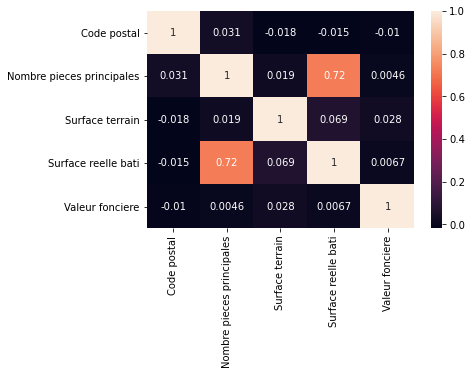

In [68]:
corrMatrix = maisons2019.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [15]:
# anomaly2 = predictor.isolationforest(appart2019)
# appartmerge = appart2019.merge(anomaly2["anomaly"], how="left", right_index=True, left_index=True)
# appartfinal = appartmerge.drop(appartmerge[(appartmerge.anomaly_x == -1) & (appartmerge.anomaly_y == -1)].index)
# appartfinal = appartfinal.drop(['scores', 'anomaly_x', 'anomaly_y'], axis=1)
# appartfinal.head()

,Code postal,Nombre pieces principales,Surface terrain,Surface reelle bati,Valeur fonciere
1,1000.0,4.0,0.0,91.0,190000.0
16,1750.0,3.0,0.0,81.0,87000.0
17,1750.0,3.0,0.0,72.0,130000.0
19,1340.0,4.0,0.0,96.0,123600.0
20,1000.0,2.0,377.0,41.0,198000.0


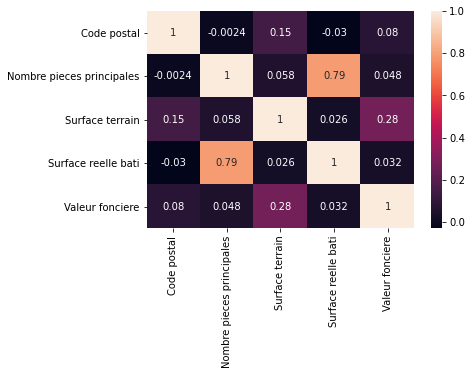

In [69]:
corrMatrix = appart2019.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

### Export des jeux de données

In [111]:
maisons2019.to_csv(cr.CURATED_LOCAL_PATH + 'filteredmaisons2019.csv', sep = '|', index=False)
appart2019.to_csv(cr.CURATED_LOCAL_PATH + 'filteredappart2019.csv', sep = '|',index=False)

In [112]:
maisons2019 = pd.read_csv(cr.CURATED_LOCAL_PATH + 'filteredmaisons2019.csv', sep="|")
appart2019 = pd.read_csv(cr.CURATED_LOCAL_PATH + 'filteredappart2019.csv', sep="|")


In [71]:
modele_lineaire_appart = predictor.trainLinearLeRetour(appart2019)

Coefficients: 
 [[ -2475.3240458  538480.75396169    670.52755554]]
Mean squared error: 227881552106768.47
Coefficient of determination: 0.08


In [75]:
predictor.predictionLinear(appart2019[appart2019.index==6], modele_lineaire_appart)

Valeur foncière estimée :  4321060.01
Valeur foncière réelle :  6    583000.0
Name: Valeur fonciere, dtype: float64


array([[4321060.00767716]])

### Split des deux datasets en départements

In [113]:
# Split des données par type de logement et par département
splitter.split_datas('filteredmaisons2019.csv', 'Code postal', 'CPMaisons')
splitter.split_datas('filteredappart2019.csv', 'Code postal', 'CPAppart')

In [114]:
appart75 = pd.read_csv(cr.CURATED_LOCAL_PATH+'CPAppart/75.csv', sep="|", encoding="utf-8")
appart75 = appart75.dropna()

In [115]:
appart75[['Valeur fonciere']] = appart75[['Valeur fonciere']].replace(',', '.', regex=True)
appart75[['Valeur fonciere']]  = appart75[['Valeur fonciere']].astype('float')

In [78]:
anomaly = predictor.isolationforest(appart75)
anomaly.head()

,Code postal,Nombre pieces principales,Surface terrain,Surface reelle bati,Valeur fonciere,scores,anomaly
20,75004.0,1.0,0.0,12.0,13800.0,-0.038515,-1
33,75004.0,2.0,0.0,29.0,15000.0,-0.035824,-1
37,75004.0,3.0,0.0,70.0,2125000.0,-0.089096,-1
38,75004.0,2.0,0.0,25.0,2125000.0,-0.089096,-1
39,75004.0,2.0,0.0,53.0,3355000.0,-0.120905,-1


### Nouveau test de prédiction à l'échelle d'un département

In [116]:
model = predictor.trainLinearLeRetour(appart75)

Coefficients: 
 [[  116479.31793831 -1674084.41542427    23293.40106442]]
Mean squared error: 58991266101866.84
Coefficient of determination: 0.78


In [117]:
predictor.predictionLinear(appart75[appart75.index==2], model)

Valeur foncière estimée :  639095.74
Valeur foncière réelle :  2    710000.0
Name: Valeur fonciere, dtype: float64


array([[639095.74415649]])

## Intégration et utilisation de l'API

In [105]:
metre_carre = 51
nb_pieces = 3
terrain = 0
code_postal = 75000

request={"metre_carre" : metre_carre, "nb_pieces" : nb_pieces, "terrain" : terrain, "code_postal" : code_postal}

url = "http://127.0.0.1:5003/api/estimate"
response = requests.get(url, params = request).json()
print(response)

{'estimate_appartment': '639095.74 €', 'estimate_house': '484413.01 €'}
